In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [2]:
df = pd.read_excel('DEFLECTION_ANALYSIS.xlsx',engine='openpyxl')

In [3]:
df.head()

,W,E,I,L,x,y
0,120000,200000000000,0.004219,15,7.5,0.093750
1,120000,200000000000,0.004219,15,1.0,0.019828
2,120000,200000000000,0.004219,15,2.0,0.038673
3,120000,200000000000,0.004219,15,3.0,0.055680
4,120000,200000000000,0.004219,15,4.0,0.070139


In [4]:
df.describe()

,W,E,I,L,x,y
count,190.000000,1.900000e+02,190.000000,190.000000,190.000000,190.000000
mean,396668.421053,3.124184e+11,0.004064,14.336842,7.665789,0.181959
std,190297.936977,1.015914e+11,0.001272,4.563741,4.896834,0.226299
min,120000.000000,2.000000e+11,0.002156,6.000000,1.000000,0.000000
25%,220000.000000,2.000000e+11,0.003235,10.000000,4.000000,0.021487
50%,360000.000000,2.750000e+11,0.003535,14.000000,7.000000,0.085636
75%,500000.000000,4.100000e+11,0.004219,19.000000,11.000000,0.246950
max,840000.000000,4.750000e+11,0.007156,20.000000,20.000000,0.785470


In [5]:
df.columns

Index(['W ', 'E', 'I', 'L', 'x', 'y'], dtype='object')

In [6]:
X = df[['W ','E','I','L','x']]
y = df['y']

In [7]:
X

,W,E,I,L,x
0,120000,200000000000,0.004219,15,7.5
1,120000,200000000000,0.004219,15,1.0
2,120000,200000000000,0.004219,15,2.0
3,120000,200000000000,0.004219,15,3.0
4,120000,200000000000,0.004219,15,4.0
...,...,...,...,...,...
185,340000,400000000000,0.003235,10,6.0
186,340000,400000000000,0.003235,10,7.0
187,340000,400000000000,0.003235,10,8.0
188,340000,400000000000,0.003235,10,9.0


## Split the data into training and testing sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBOOST

In [9]:
regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [10]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.000692560768093463


In [11]:
new_df = X_test.copy()

In [12]:
new_df['y_test'] = y_test
new_df['y_pred'] = y_pred

In [13]:
new_df.head()

,W,E,I,L,x,y_test,y_pred
175,360000,423700000000,0.003535,9,5.0,0.020232,0.021430
180,340000,400000000000,0.003235,10,1.0,0.010741,0.011398
111,740000,475000000000,0.007156,14,11.0,0.068554,0.058128
65,350000,200000000000,0.003456,12,6.0,0.136737,0.125080
101,740000,475000000000,0.007156,14,1.0,0.024648,0.030376


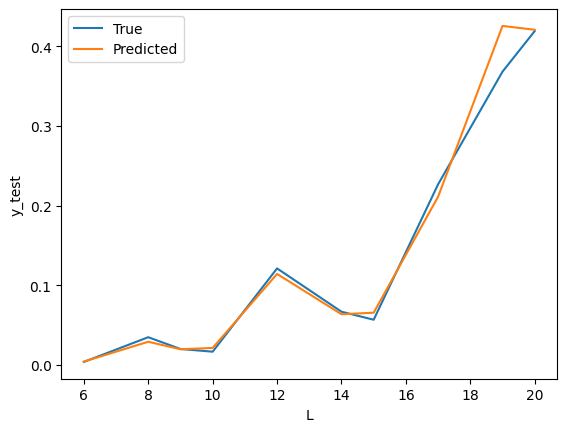

In [14]:
sns.lineplot(x=new_df['L'],y=new_df['y_test'], errorbar=None, label='True')
sns.lineplot(x=new_df['L'],y=new_df['y_pred'], errorbar=None, label='Predicted')
plt.show()

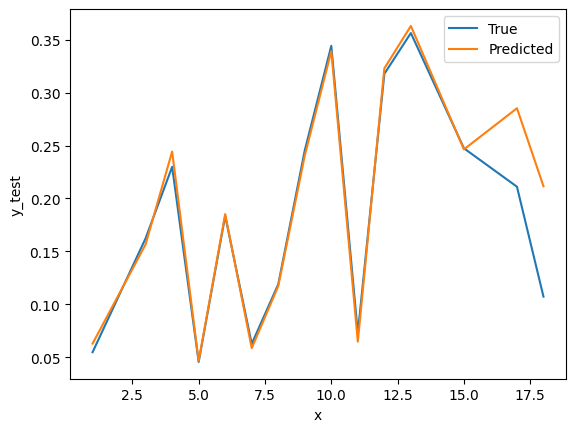

In [15]:
sns.lineplot(x=new_df['x'],y=new_df['y_test'], errorbar=None, label='True')
sns.lineplot(x=new_df['x'],y=new_df['y_pred'], errorbar=None, label='Predicted')
plt.show()

# LIGHTBGM

In [16]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [17]:
params = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [18]:
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data],callbacks=[lgb.early_stopping(stopping_rounds=3),])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.182092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

<Figure size 1000x600 with 0 Axes>

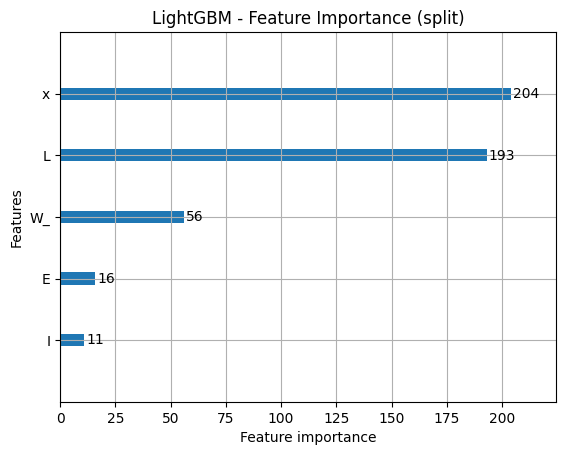

In [19]:
plt.figure(figsize=(10, 6))
lgb.plot_importance(bst, max_num_features=10, importance_type='split')
plt.title('LightGBM - Feature Importance (split)')
plt.show()

In [20]:
y_pred_lbgm = bst.predict(X_test, num_iteration=bst.best_iteration)

In [21]:
lbgm_df = X_test.copy()
lbgm_df['y_test'] = y_test
lbgm_df['y_pred'] = y_pred_lbgm

In [22]:
lbgm_df.head()

,W,E,I,L,x,y_test,y_pred
175,360000,423700000000,0.003535,9,5.0,0.020232,0.024541
180,340000,400000000000,0.003235,10,1.0,0.010741,0.004341
111,740000,475000000000,0.007156,14,11.0,0.068554,0.064023
65,350000,200000000000,0.003456,12,6.0,0.136737,0.096819
101,740000,475000000000,0.007156,14,1.0,0.024648,0.018944


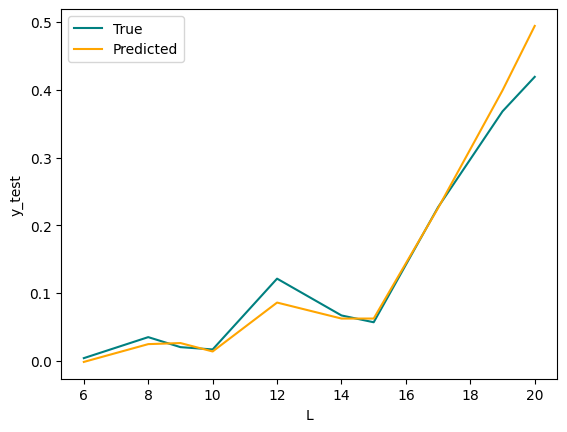

In [23]:
sns.lineplot(x=lbgm_df['L'],y=lbgm_df['y_test'], errorbar=None,color='teal', label='True')
sns.lineplot(x=lbgm_df['L'],y=lbgm_df['y_pred'], errorbar=None, color='orange', label='Predicted')
plt.show()


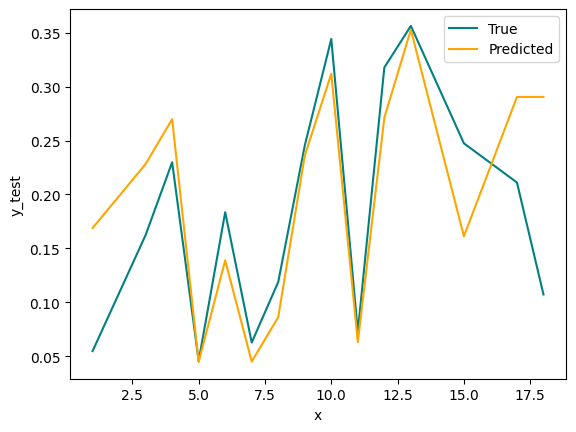

In [24]:
sns.lineplot(x=lbgm_df['x'],y=lbgm_df['y_test'], errorbar=None,color='teal', label='True')
sns.lineplot(x=lbgm_df['x'],y=lbgm_df['y_pred'], errorbar=None, color='orange', label='Predicted')
plt.show()